# Evaluation of the neural segmentation models

This notebook contains the main results of the paper, where we evaluate the baseline and neural models on both portions of the dataset, and vary the number of training samples for the neural models. We use several evaluation functions from from the `evluation.py` file to perform the evaluation. Note that we have already performed the training and evaluation beforehand, as this can take quite some time, especially on a CPU. Both the training scripts and the trained models are provided if you wish to use these models yourself.

## Index

1. [Standard Experiment](#standard_experiment)

<a id="standard_experiment"><h2>Standard Experiment</h2></a>

We will start by loading in the the predictions of the models and the ground truth, and do some small visualizations, after which we compare the scores of all the three models.

In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from glob import glob
import pycocotools.coco
from skimage import measure
from torchvision.ops import nms
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.mask import decode, encode, merge, iou, area, frPyObjects    

# Import the evaluation code
from evaluation import *

In [2]:
import cv2
from PIL import Image
def load_image(image_path: str) -> np.ndarray:
    """
    Function that loads an image from a path.
    :param image_path: string specifying the path to the image
    :return: Numpy array with the image in BGR format.
    """
    image = Image.open(image_path)
    return image

In [3]:
import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
# write a function that can nicely display ground truth and predicted and ground truth masks
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes

from pycocotools.mask import decode, encode, merge, area, frPyObjects, toBbox  

def visualize_annotations(image_filename, gold_standard_json, predicted_json, score_treshold: float=0.5,
                         vis_mode: str ='masks'):
    
    assert vis_mode in ['masks', 'boxes']
    
    plt.rcParams["figure.figsize"] = (20, 20)
    image_path = os.path.join("/".join(gold_standard_json.split('/')[:-1]), 'images', image_filename)
    im_arr = torch.from_numpy(np.array(load_image(image_path))).permute(2, 0, 1)

    with open(gold_standard_json, 'r') as f:
        ground_truth_json = json.load(f)
        
    
    with open(predicted_json, 'r') as f:
        predicted_json = json.load(f)
        
    # Add ids to anontations
    if isinstance(predicted_json, list):
        for i in range(len(predicted_json)):
            predicted_json[i]['id'] = i+1
    else:
        predicted_json = predicted_json['annotations']
        
    image = [item for item in ground_truth_json['images'] if item['file_name'] == image_filename][0]
    image_id = image['id']
    scores = {'TP': [], 'FP': [], 'FN': [], 'IOU': []}

    ground_truth_annotations = [item for item in ground_truth_json['annotations'] if item['image_id'] == image_id]
    predicted_annotations = [item for item in predicted_json if item['image_id'] == image_id]
    filtered_predicted_annotations = [item for item in predicted_annotations if area(item['segmentation']) > 0 and (item['score'] > score_treshold)]
    print(len(filtered_predicted_annotations))
    TP = []
    IOU = []

    # Next we will have to filter the annotations, as some have an overlap that is too big
    # or where the confidence threshold is too low.
    ground_truth_indices = [item['id'] for item in ground_truth_annotations]
    pred_indices = [item['id'] for item in filtered_predicted_annotations]


    for gt_annot in ground_truth_annotations:
        for pred_annot in filtered_predicted_annotations:

            gt_mask = gt_annot['segmentation']
            pred_mask = pred_annot['segmentation']

            combined_area = area(merge([gt_mask, pred_mask]))
            intersected_area = area(merge([gt_mask, pred_mask], intersect=True))
            iou_score = intersected_area/combined_area

            if iou_score > 0.5:
                TP.append([gt_annot['id'], pred_annot['id']])
                IOU.append(iou_score)

    FP = set(pred_indices) - set([item[1] for item in TP])
    FN = set(ground_truth_indices) - set([item[0] for item in TP])
    
    decode_func = decode if vis_mode == 'masks' else toBbox
    
    FP_objects = [decode_func(item['segmentation']) for item in filtered_predicted_annotations if item['id'] in FP]
    FN_objects = [decode_func(item['segmentation']) for item in ground_truth_annotations if item['id'] in FN]
    TP_objects = [decode_func(item['segmentation']) for item in filtered_predicted_annotations if item['id'] in [it[1] for it in TP]]
    
    if FP_objects:
        FP_objects = np.stack(FP_objects)
    if FN_objects:
        FN_objects = np.stack(FN_objects)
    if TP_objects:
        TP_objects = np.stack(TP_objects)
    
    all_objects = np.concatenate([item for item in [FP_objects, FN_objects, TP_objects] if isinstance(item, np.ndarray)])
    colors = ['red' for _ in range(len(FP_objects))] +  ['yellow' for _ in range(len(FN_objects))] + ['green' for _ in range(len(TP_objects))]
    if vis_mode == 'masks':
        show(draw_segmentation_masks(im_arr, torch.tensor(all_objects).bool(), colors=colors))
    else:
        all_boxes = box_convert(torch.tensor(all_objects), in_fmt='xywh', out_fmt='xyxy')
        show(draw_bounding_boxes(im_arr, all_boxes, colors=colors, width=5))
        
    plt.show()

The first step is loading in the classic dataset and then run the evaluation of all three models.

In [5]:
gold_standard_clean = read_json('../dataset/test/classic_test.json')
maskrcnn_clean_predictions = read_json('../model_outputs/MaskRCNN_clean/coco_instances_results.json')
mask2former_clean_predictions = read_json('../model_outputs/Mask2Former_clean/coco_instances_results.json')
rulebased_clean_predictions = read_json('../model_outputs/Morphology_clean/coco_instances_results.json')

In [6]:
maskrcnn_clean_results = evaluate_predictions(gold_standard_clean['annotations'],
                                                             maskrcnn_clean_predictions,
                                              confidence_score=0.0, iou_score=0.00,
                                             count_empty_pages=False)
mask2former_clean_results = evaluate_predictions(gold_standard_clean['annotations'],
                                                             mask2former_clean_predictions,
                                                confidence_score=0.0, iou_score=0.00,
                                                count_empty_pages=False)

rulebased_clean_results = evaluate_predictions(gold_standard_clean['annotations'],
                                                             rulebased_clean_predictions,
                                              do_filtering=False)

100%|█████████████████████████████████████████| 281/281 [00:03<00:00, 86.85it/s]


In [7]:
classic_results = pd.concat([calculate_color_specific_metrics(rulebased_clean_results)[['black', 'color', 'gray', 'border', 'total']],
                             calculate_color_specific_metrics(maskrcnn_clean_results)[['black', 'color', 'gray', 'border', 'total']],
                             calculate_color_specific_metrics(mask2former_clean_results)[['black', 'color', 'gray', 'border', 'total']]],
                            axis=1,
                           keys=["Morphology", "MaskRCNN", "Mask2Former"]).T[['SQ', 'P', 'R', 'F1']]

In [8]:
PQ_calculation(mask2former_clean_results)

{'SQ': 0.82, 'F1': 0.67, 'P': 0.52, 'R': 0.95}

# Extended dataset results

After these results we will do the other set of experiments, this time on the extended dataset that also contains apges without redactions.

In [9]:
gold_standard_extended = read_json('../dataset/test/extended_test.json')
maskrcnn_extended_predictions = read_json('../model_outputs/MaskRCNN_extended/coco_instances_results.json')
mask2former_extended_predictions = read_json('../model_outputs/Mask2Former_extended/coco_instances_results.json')
rulebased_extended_predictions = read_json('../model_outputs/Morphology_extended/coco_instances_results.json')

In [19]:
maskrcnn_extended_results = evaluate_predictions(gold_standard_extended['annotations'],
                                                             maskrcnn_extended_predictions,
                                              confidence_score=0.7,
                                                count_empty_pages=True,
                                                iou_score=0.2)
mask2former_extended_results = evaluate_predictions(gold_standard_extended['annotations'],
                                                             mask2former_extended_predictions,
                                                confidence_score=0.7,
                                                   count_empty_pages=True,
                                                   iou_score=0.2)
rulebased_extended_results = evaluate_predictions(gold_standard_extended['annotations'],
                                                             rulebased_extended_predictions,
                                              do_filtering=False,
                                                 count_empty_pages=True)

100%|█████████████████████████████████████████| 281/281 [00:03<00:00, 86.81it/s]


In [20]:
classic_results = pd.concat([calculate_color_specific_metrics(rulebased_extended_results)[['black', 'color', 'gray', 'border', 'total']],
                             calculate_color_specific_metrics(maskrcnn_extended_results)[['black', 'color', 'gray', 'border', 'total']],
                             calculate_color_specific_metrics(mask2former_extended_results)[['black', 'color', 'gray', 'border', 'total']]],
                            axis=1,
                           keys=["Morphology", "MaskRCNN", "Mask2Former"]).T[['SQ', 'P', 'R', 'F1']]

/Users/rubenvanheusden/Desktop/IJDARKaj/notebooks/evaluation.py:88: RuntimeWarning: invalid value encountered in long_scalars
  R = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FN'].sum())
/Users/rubenvanheusden/Desktop/IJDARKaj/notebooks/evaluation.py:88: RuntimeWarning: invalid value encountered in long_scalars
  R = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FN'].sum())
/Users/rubenvanheusden/Desktop/IJDARKaj/notebooks/evaluation.py:88: RuntimeWarning: invalid value encountered in long_scalars
  R = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FN'].sum())


In [21]:
PQ_calculation(maskrcnn_extended_results)

{'SQ': 0.84, 'F1': 0.9, 'P': 0.92, 'R': 0.88}

In [22]:
PQ_calculation(mask2former_extended_results)

{'SQ': 0.84, 'F1': 0.87, 'P': 0.94, 'R': 0.81}

## Training Variation Experiments

In [14]:
import seaborn as sns
sns.set(style="ticks")
sns.set_style("darkgrid")

def create_training_df(list_of_dataframes: list):
    number_of_samples = [10, 20, 40, 60, 80, 100]
    out_df = {}
    for i, item in enumerate(list_of_dataframes):
        train_metrics = metric_calculation(item)
        out_df[number_of_samples[i]] = train_metrics
    return pd.DataFrame(out_df).T
    

NameError: name 'mask2former_training' is not defined

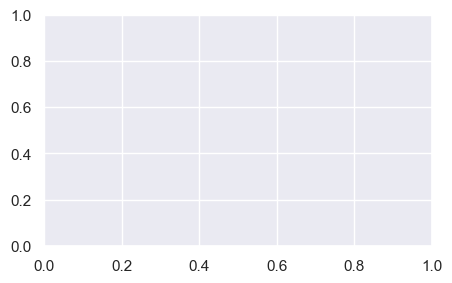

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

# create_training_df(maskrcnn_training).plot(ax=axes, ylim=(0.6, 1),
#                                           style=['-', '--', '-.', ':'])
create_training_df(mask2former_training).plot(ax=axes, ylim=(0.6, 1),
                                             style=['-', '--', '-.', ':'])

axes.set_xlabel("Percentage of training data")
plt.savefitg('../mask2former_training.png')